# Evaluation of intended filters (by Jonas Schenker)

Here we want to find out which filter (Gaussian or Bilateral) works best in comparison to the unfiltered images using the Dice score and the image Otsu_t13.tiff

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os # To save images
from matplotlib import colors # To convert image models
import cv2 as cv2 # To apply filters

In [3]:
from Functions.FinalKMeans import preprocess_rgb
from Functions.FinalKMeans import preprocess_grayscale
from Functions.FinalKMeans import preprocess_hsv
from Functions.FinalKMeans import preprocess_image
from Functions.FinalKMeans import init_centroids
from Functions.FinalKMeans import assign_to_centroids
from Functions.FinalKMeans import update_centroids
from Functions.FinalKMeans import kmeans
from Functions.FinalKMeans import reconstruct_segmented_image
from Functions.FinalKMeans import save_image
from Functions.FinalKMeans import save_image_universal
from Functions.Datenvorbereitung import apply_median_filter 
from Functions.Colormodels import plot_hsv_channels

In [4]:
gray_t13_bilateral = np.copy(plt.imread('Images/Datenvorbereitung_images/Otsu/Filtered_t13/t13_bilateral.tiff'))
gray_t13_gauß = np.copy(plt.imread('Images/Datenvorbereitung_images/Otsu/Filtered_t13/t13_gauß.tiff'))
gray_t13_median = apply_median_filter(np.copy(plt.imread('Original_Images/Otsu/Data/N2DL-HeLa/img/t13.tif')), kernel = 5)
gray_t13 = np.copy(plt.imread('Original_Images/Otsu/Data/N2DL-HeLa/img/t13.tif'))






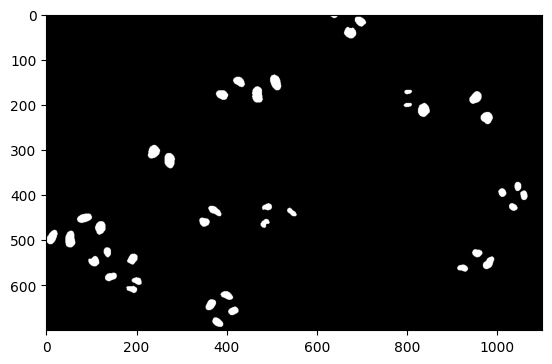

In [5]:
centroids_gray_t13_bilateral, labels_gray_t13_bilateral, clustered_gray_t13_bilateral = kmeans(gray_t13_bilateral, k=2, init_method='kmeans++', space='gray')
centroids_gray_t13_gauß, labels_gray_t13_gauß, clustered_gray_t13_gauß = kmeans(gray_t13_gauß, k=2, init_method='kmeans++', space='gray')
centroids_gray_t13_median, labels_gray_t13_median, clustered_gray_t13_median = kmeans(gray_t13_median, k=2, init_method='kmeans++', space='gray')
centroids_gray_t13, labels_gray_t13, clustered_gray_t13 = kmeans(gray_t13, k=2, init_method='kmeans++', space='gray')

plt.imshow(clustered_gray_t13_median, cmap='gray')

In [6]:
#save_image_universal(clustered_gray_t13, 'Images/Segmented_Images/t13_for_filterevaluation/clustered_gray_t13_norm.png', space='gray')
#save_image_universal(clustered_gray_t13_bilateral, 'Images/Segmented_Images/t13_for_filterevaluation/clustered_gray_t13_bilateral_norm.png', space='gray')
#save_image_universal(clustered_gray_t13_gauß, 'Images/Segmented_Images/t13_for_filterevaluation/clustered_gray_t13_gauß_norm.png', space='gray')
#save_image_universal(clustered_gray_t13_median, 'Images/Segmented_Images/t13_for_filterevaluation/clustered_gray_t13_median(5)_norm.png', space='gray')

Testing out Thresholding of YeastCells for image segmentation (from KMeans.ipynb) with HSV model (all channels --> worked best in not filtered image)

Threshold in RGB:

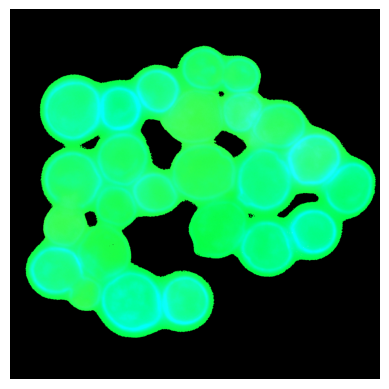

In [19]:
RGB_YeastCells = np.copy(plt.imread('Original_Images/Clustering/Data/Yeast_Cells.jpg'))
# Set threshold (e.g., 0.2 for normalized images, otherwise 50 for 8-bit)
threshold = 0.28 if RGB_YeastCells.max() <= 1.0 else 61

# mask: all pixels where all RGB channels are below the threshold
mask = np.all(RGB_YeastCells < threshold, axis=2)

# set rgb values to 0 where the mask is True
RGB_YeastCells[mask] = 0

#Normalize data
RGB_YeastCells = np.copy(RGB_YeastCells.astype(float))
RGB_YeastCells = (RGB_YeastCells - RGB_YeastCells.min()) / (RGB_YeastCells.max() - RGB_YeastCells.min())

#Drop alpha channel if present
if RGB_YeastCells.ndim == 3 and RGB_YeastCells.shape[2] == 4:
    RGB_YeastCells = RGB_YeastCells[..., :3]
else:
    RGB_YeastCells = RGB_YeastCells

HSV_threshold_YeastCells = colors.rgb_to_hsv(RGB_YeastCells)

# show image
plt.imshow(HSV_threshold_YeastCells)
plt.axis('off')
plt.show()

Cluster thresholded image in hsv

In [20]:
centroids_HSV_YeastCells_threshold, labels_HSV_YeastCells_threshold, clustered_HSV_YeastCells_threshold = kmeans(HSV_threshold_YeastCells, k=2, init_method='kmeans++', space='hsv')

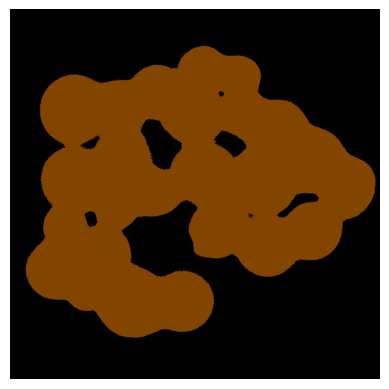

In [21]:
plt.imshow(clustered_HSV_YeastCells_threshold)
plt.axis('off')
plt.show()

In [22]:
save_image_universal(clustered_HSV_YeastCells_threshold, 'Images/Segmented_Images/t13_for_filterevaluation/clustered_HSV_YeastCells_threshold.png', space='hsv')

Testing Halo reduction in Hue channel

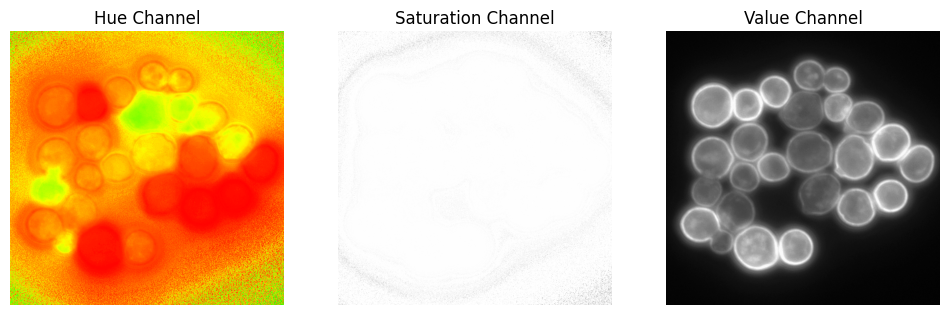

(array([[[0.11764706, 1.        , 0.00784314, 1.        ],
         [0.11764706, 1.        , 0.00784314, 1.        ],
         [0.02352941, 1.        , 0.01960784, 1.        ],
         ...,
         [0.23529412, 1.        , 0.01568628, 1.        ],
         [0.23529412, 1.        , 0.00784314, 1.        ],
         [0.1764706 , 1.        , 0.00784314, 1.        ]],
 
        [[0.1764706 , 1.        , 0.01568628, 1.        ],
         [0.1764706 , 1.        , 0.01568628, 1.        ],
         [0.07843138, 1.        , 0.01176471, 1.        ],
         ...,
         [0.19607843, 0.7490196 , 0.01568628, 1.        ],
         [0.11764706, 1.        , 0.00392157, 1.        ],
         [0.11764706, 1.        , 0.00392157, 1.        ]],
 
        [[0.21568628, 1.        , 0.02352941, 1.        ],
         [0.16470589, 1.        , 0.01960784, 1.        ],
         [0.11764706, 0.6666667 , 0.01176471, 1.        ],
         ...,
         [0.25882354, 1.        , 0.01960784, 1.        ],
        

In [ ]:
# Hue channel without thresholding
HSV_YeastCells = np.copy(plt.imread('Images/Datenvorbereitung_Images/YeastCells/HSV_Yeast/HSV_YeastCells.png'))
plot_hsv_channels(HSV_YeastCells)


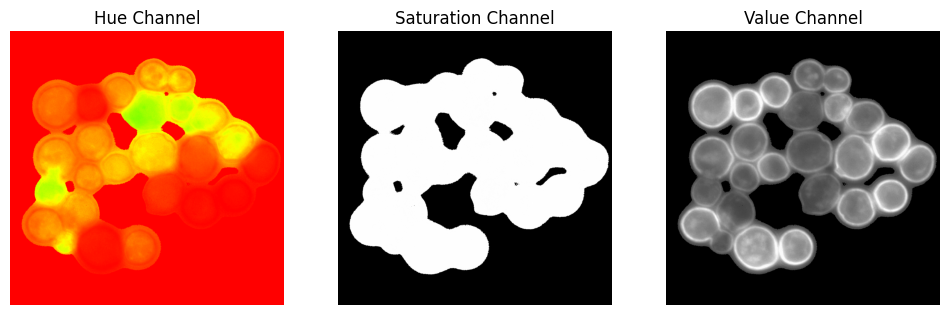

(array([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], shape=(1200, 1200, 3)),
 array([[0., 0., 0., ..., 0., 0.

In [24]:
# Hue channel with thresholding
plot_hsv_channels(HSV_threshold_YeastCells)

As a result we can say that using thresholding improves especially the hue channel, moreover regarding the "improved" saturation channel could lead to more precise image segmentation --> needs to be tested via dice score.